In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Conv1D,Add,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import pandas as pd
from tqdm import tqdm
import os
import natsort
from glob import glob
import numpy as np
import warnings
import json

warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices, 'GPU')

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # GPU 사용 가능
    for gpu in gpus:
        print("GPU:", gpu)
else:
    # GPU 사용 불가능
    print("GPU not found")

GPU not found


### Data load 

<AxesSubplot:>

100%|██████████| 2193/2193 [00:03<00:00, 654.57it/s]


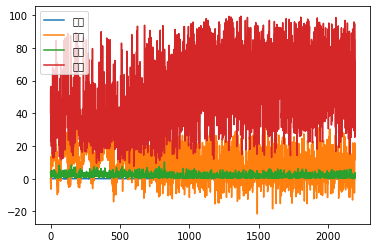

In [10]:
image_size=24

path=f"../data/train_data/"

height_train=np.load(path+'Height_train.npy')
ndvi_train=np.load(path+'NDVI_train.npy')
slope_train=np.load(path+'Slope_train.npy')
landuse_train=np.load(path+'Landuse_train.npy')
popden_train=np.load(path+'Pop_train.npy')

tabular_data=pd.read_csv(path+"Weather_data.csv",encoding='cp949')
tabular_data.drop(['lon', 'lat'],axis=1,inplace=True)
tabular_data=tabular_data.replace(32767.0,-9999)
#tabular_data=tabular_data.replace(-9999.0,0)
tabular_data[['강수','기온','풍속','습도']].plot()
x,y=[],[]
for j in tqdm(range(len(tabular_data))):
    x.append(np.array(tabular_data.loc[j, ['습도', '강수', '기온', '풍속']]).astype(float))
    y.append(np.array(tabular_data.loc[j, ['target']]).astype(float))
climate = np.array(x)
y = np.array(y)

In [12]:
height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
climate_input = Input(shape=(4,1), name='climate_input')

def residual_block(input_layer, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    
    if input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)
    
    x = Add()([input_layer, x])
    x = Activation('relu')(x)
    return x

def res_layers(input_layer):
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, 64, (3, 3))
    x = residual_block(x, 64, (3, 3))
    
    x = residual_block(x, 128, (3, 3))
    x = residual_block(x, 128, (3, 3))
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return x

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    flatten = Flatten()(pool4)
    
    dense1 = Dense(128, activation='relu')(flatten)
    
    return dense1


def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
height_cnn = cnn_layers(height_input)
ndvi_cnn = cnn_layers(ndvi_input)
slope_cnn = cnn_layers(slope_input)
landuse_cnn = cnn_layers(landuse_input)
popden_cnn = cnn_layers(popden_input)
climate_cnn = dense_layer(climate_input)

merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn, climate_cnn])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

model = Model(inputs=[height_input, ndvi_input,slope_input,landuse_input,popden_input,climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 height_input (InputLayer)      [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 ndvi_input (InputLayer)        [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 slope_input (InputLayer)       [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 landuse_input (InputLayer)     [(None, 24, 24, 3)]  0           []                               
                                                                                              

In [19]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 입력층 정의
height_input = Input(shape=(24, 24, 3), name='height_input')
ndvi_input = Input(shape=(24, 24, 3), name='ndvi_input')
slope_input = Input(shape=(24, 24, 3), name='slope_input')
landuse_input = Input(shape=(24, 24, 3), name='landuse_input')
popden_input = Input(shape=(24, 24, 3), name='popden_input')
climate_input = Input(shape=(4, 1), name='climate_input')

# MobileNet 모델 불러오기
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(24, 24, 3))
mobilenet.trainable = False  # MobileNet의 가중치 고정

# MobileNet 모델의 레이어를 가져와서 입력층으로 사용
mobilenet_input = mobilenet.input
mobilenet_output = mobilenet.output

# CNN 레이어 정의
def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2, 2))(conv1_im)

    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    flatten = Flatten()(pool4)

    dense1 = Dense(128, activation='relu')(flatten)

    return dense1

# CNN 레이어를 사용하여 입력층을 MobileNet의 출력층으로 대체
height_cnn = cnn_layers(mobilenet_output)
ndvi_cnn = cnn_layers(mobilenet_output)
slope_cnn = cnn_layers(mobilenet_output)
landuse_cnn = cnn_layers(mobilenet_output)
popden_cnn = cnn_layers(mobilenet_output)
climate_cnn = dense_layer(climate_input)


# 모든 입력층을 병합
merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn, climate_cnn])

# 출력층 정의
output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

# 모델 정의
model = Model(inputs=[height_input, ndvi_input, slope_input, landuse_input, popden_input, climate_input], outputs=output_layer)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary')


ValueError: Input size must be at least 32x32; Received: input_shape=(24, 24, 3)

In [7]:
x_train = {
    'height_input': height_train,
    'ndvi_input': ndvi_train,
    'slope_input': slope_train,
    'landuse_input': landuse_train,
    'popden_input': popden_train,
    'climate_input':climate
}

In [8]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95:
            print("Reached accuracy threshold (0.9). Stopping training.")
            self.model.stop_training = True
model.fit(x_train, y, epochs=100, batch_size=256, callbacks=[AccuracyThresholdCallback()])

Epoch 1/100
9/9 [==============================] - 1s 5ms/step - loss: 0.7994 - accuracy: 0.3899
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.5837
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6484
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6027 - accuracy: 0.6794
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.5955 - accuracy: 0.6808
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.6817
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5908 - accuracy: 0.6840
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.6840
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6845
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5879 - accuracy: 0.6849
Epoch 11/100
9/9 [===========

In [9]:
#model.save(f"C:/Users/user/fire_model/{path}{image_size}/cnn") 
model.save(f"C:/Users/user/fire_model/try/cnn4onlyclimate") 

INFO:tensorflow:Assets written to: C:/Users/user/fire_model/try/cnn4onlyclimate\assets


In [80]:
y_pred = model.predict(x_test)
y_pred

13/13 [==============================] - 0s 24ms/step


array([[0.9511119 ],
       [0.6638504 ],
       [0.9243032 ],
       [0.36866847],
       [0.96533704],
       [0.50629115],
       [0.894358  ],
       [0.7636744 ],
       [0.99814063],
       [0.5209027 ],
       [0.9760125 ],
       [0.9424071 ],
       [0.9863269 ],
       [0.935752  ],
       [0.92519057],
       [0.67485106],
       [0.98790586],
       [0.9989828 ],
       [0.99818   ],
       [0.9968638 ],
       [0.98516494],
       [0.9779872 ],
       [0.9956075 ],
       [0.7364466 ],
       [0.93447095],
       [0.6338504 ],
       [0.97422516],
       [0.9690676 ],
       [0.77703154],
       [0.9968832 ],
       [0.7898568 ],
       [0.91756684],
       [0.99230975],
       [0.7502356 ],
       [0.9647244 ],
       [0.99972296],
       [0.9894323 ],
       [0.9992107 ],
       [0.8908258 ],
       [0.9659373 ],
       [0.7065911 ],
       [0.9215959 ],
       [0.8963555 ],
       [0.8801547 ],
       [0.99681   ],
       [0.99954003],
       [0.8433061 ],
       [0.938

In [81]:
#forest_input = Input(shape=(32, 32, 3), name='forest_input')
height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
forest_input = Input(shape=(image_size, image_size, 3), name='forest_input')
climate_input = Input(shape=(4,1), name='climate_input')

def residual_block(input_layer, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    
    if input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)
    
    x = Add()([input_layer, x])
    x = Activation('relu')(x)
    return x

def res_layers(input_layer):
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, 64, (3, 3))
    x = residual_block(x, 64, (3, 3))
    
    x = residual_block(x, 128, (3, 3))
    x = residual_block(x, 128, (3, 3))
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return x

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    flatten = Flatten()(pool3)
    
    dense1 = Dense(128, activation='relu')(flatten)
    
    return dense1


def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
#forest_cnn = cnn_layers(forest_input)
height_cnn = cnn_layers(height_input)
ndvi_cnn = cnn_layers(ndvi_input)
slope_cnn = cnn_layers(slope_input)
landuse_cnn = cnn_layers(landuse_input)
popden_cnn = cnn_layers(popden_input)
forest_cnn = cnn_layers(forest_input)
climate_cnn = dense_layer(climate_input)

merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn,forest_cnn, climate_cnn])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

model = Model(inputs=[height_input, ndvi_input,slope_input,landuse_input,popden_input,forest_input,climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

378